In [99]:
import pymysql
import numpy as np
import pandas as pd
import datetime as dtt
import matplotlib.pyplot as plt
from database import Data
import statsmodels.api as sm
from pylab import mpl
from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter

In [2]:
class Data(object):
    """本类用于从mysql中提取相应条件的数据"""
    def __init__(self, sql, cur, args=None):
        self.sql = sql
        self.cur = cur
        self.args = args
        self.data = Data.get_data(self)

    def __str__(self):
        return str(self.data)

    __repr__ = __str__

    def get_data(self):
        _ = self.cur.execute(self.sql, self.args)
        data = self.cur.fetchall()
        return data

    def select_col(self, col):
        return [d[col] for d in self.data]

In [3]:
db = pymysql.connect("localhost", "root", "root", "strategy1", charset="utf8")
cur = db.cursor()

In [4]:
class ImpFuture(object):
    """用于统计发行冲击后的国债期货表现"""
    def __init__(self, cur, db):
        self.cur = cur
        self.db = db

    def imp_days(self, bond_type, future_type):
        """将发行冲击五等分，计算之后4日的国债期货收益均值，参数bond_type为续发债类型，分别为
        国债和国开债，future_type为国债期货合约类型("TF"或者"T")"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_term")
        sql1 = """select t1.delta, t2.dsrate, t3.dsrate, t4.dsrate, t5.dsrate
        from impact t1 inner join future_delta t2 inner join future_delta t3
        inner join future_delta t4 inner join future_delta t5
        on t1.dt = t2.dt and t3.seq = t2.seq + 1 and t4.seq = t3.seq+1 and t5.seq = t4.seq+1
        and t3.term = t2.term and t4.term = t3.term and t5.term = t4.term
        and t1.bondtype = %s and t2.term = %s
        order by t1.delta
        """
        data = Data(sql1, self.cur, (bond_type, future_term)).data
        data = pd.DataFrame(np.array(data), columns=["delta", "first", "second", "third", "fourth"])
        # 依据delta将data五等分
        n = 5
        res = []
        l = int(len(data)/n)
        for i in range(n):
            a = i*l
            b = (i+1)*l-1
            if i == 4:
                b = -1
            d = list(data[a:b].mean())
            d.insert(1, len(data[a:b]))
            res.append(d)
        return res

    def imp_minutes(self, bond_type, future_type, day=0):
        """计算发行冲击当日的五分钟级的市场走势"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_type")
        # 获得delta五等分点
        sql1 = """select t1.delta from impact t1 inner join future_minute t2
                  on t1.dt = date(t2.dtt) and t2.seq=0
                  where t1.bondtype = %s and t2.term = %s
                  """
        delta = np.array(Data(sql1, self.cur, (bond_type, future_term)).data)
        delta = pd.DataFrame(delta, columns=["delta"]).dropna()
        per_delta = [float(delta.min()-1)]
        for p in range(20, 120, 20):
            per_delta.append(float(np.percentile(delta, p)))
        # 根据五等分点（per_delta)从数据库中选出每个分位的
        data = []
        if day == 0:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2
            on t1.dt = date(t2.dtt) and t1.bondtype = %s and t2.term = %s 
            and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')"""
        elif day > 0:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2 inner join dts1 t3 inner join dts1 t4
            on t1.dt = t3.dt and t4.seq = t3.seq +{} and t4.dt = date(t2.dtt)
            where t1.bondtype = %s and t2.term = %s and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')
            """.format(day)
        else:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2 inner join dts1 t3 inner join dts1 t4
            on t1.dt = t3.dt and t4.seq = t3.seq - {} and t4.dt = date(t2.dtt)
            where t1.bondtype = %s and t2.term = %s and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')
            """.format(abs(day))
        for i in range(len(per_delta)-1):
            a = per_delta[i]
            b = per_delta[i+1]
            da = Data(sql2, self.cur, (bond_type, future_term, a, b))
            time_index = da.select_col(0)
            rate = da.select_col(1)
            data.append(rate)
        data = np.array(data).T
        res = []
        for k in range(1, len(data), 1):
            res.append(100*(data[k] - data[0]))
        res = pd.DataFrame(res, index=time_index[1:], columns=["一", "二", "三", "四", "五"])
        return res

    def imp_minutes_plot(self, day=0):
        """将利率债发行对国债期货市场的影响可视化，即分别以国债-TF、国债-T、国开债-TF、国开债-T作为参数
        计算imp_minutes，并将结果放入一张4×1的图中"""
        imp_minutes_params = [("国债", "TF"), ("国债", "T"), ("国开债", "TF"), ("国开债", "T")]
        fig, axes = plt.subplots(4, 1, figsize=(8,12), sharex="all", )
        xmajorLocator = MultipleLocator(4)
        for params, ax in zip(imp_minutes_params, axes):
            data =  self.imp_minutes(*params, day)
            ax.spines["top"].set_color("none")
            ax.spines["right"].set_color("none")
            ax.xaxis.set_ticks_position("bottom")
            ax.yaxis.set_ticks_position("left")
            labels = ["一", "二", "三", "四", "五"]
            for i in range(len(labels)):
                ax.plot(data.index, data.iloc[:, i], label=labels[i])
            ax.spines["bottom"].set_position(('data', 0))
            ax.xaxis.set_major_locator(xmajorLocator)
            ax.set_title("{}-{}".format(*params))
            ax.legend(loc="best")
        fig.show()
    
    def imp_days_minutes(self, day1, day2, future_type, bond_type="国债", delta_type="delta", k=5, p2r_mode=0):
        """计算发行前day1日至发行后day2日的国债期货五分钟行情序列，k为等分数，默认为5等分"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_type")
        dt0 = dtt.date(2016, 2, 15)
        dt1 = dt0 + dtt.timedelta(days=day1)
        sdt = dt1.strftime("%Y-%m-%d")
        sql1 = """
        select t1.dt, t1.term, t1.{0}, t2.dt, t3.dt, t1.bondtype
        from impact t1 inner join dts1 t2 inner join dts1 t3 inner join dts1 t4
        on t1.dt = t4.dt and t2.seq = t4.seq - %s and t3.seq = t4.seq + %s and t1.bondtype = "{1}"
        where t1.{0} is not null and t1.dt >= '{2}'
        order by t1.{0}
        """.format(delta_type, bond_type, sdt)
        data1 = Data(sql1, self.cur, (day1, day2)).data
        num = len(data1)  # 提取记录的个数，用于
        print(num)
        # 提取交易行情序列
        data2 = []
        sql2 = """
        select close from future_minute
        where date(dtt) between %s and %s and term = {}
        """.format(future_term)
        for d1 in data1:
            d2 = Data(sql2, self.cur, (d1[3], d1[4])).select_col(0)
            d2 = p2r(d2, mode=p2r_mode)
            data2.append(d2)
        n = round(num / k)  # 每个分位的记录个数
        res = []  # 结果res用于保存
        for i in range(k):
            a = i * n
            if i == k - 1:
                b = num
            else:
                b = n * (i + 1)
            r = np.mean(data2[a:b], axis=0)
            res.append(r)
        return res

In [5]:
def p2r(price, mode=0):
    """将价格时间序列转换为收益率序列，默认为以初始值为基准，当mode为0时返回原价格序列，若为1则返回涨跌幅"""
    if mode == 0:
        res = price
    elif mode == 1:
        p0 = price[0]  # 初始价格
        res = [100 * (p - p0) / p0 for p in price]
    return res


def trading_time(dt, minute_delta=5):
    """生成交易日的交易时间序列，minute_delta是时间间隔，默认为5分钟"""
    res = []
    dt_time0 = dtt.datetime(dt.year, dt.month, dt.day, 9, 20, 0)
    dt_time1 = dtt.datetime(dt.year, dt.month, dt.day, 11, 30, 0)
    dt_time2 = dtt.datetime(dt.year, dt.month, dt.day, 13, 5, 0)
    dt_time3 = dtt.datetime(dt.year, dt.month, dt.day, 15, 15, 0)
    dt_times_am = []
    dt_times_pm = []
    dt_time = dt_time0
    while dt_time <= dt_time1:
        dt_times_am.append(dt_time)
        dt_time += dtt.timedelta(minutes=minute_delta)
    res.extend(dt_times_am)
    dt_time = dt_time2
    while dt_time <= dt_time3:
        dt_times_pm.append(dt_time)
        dt_time += dtt.timedelta(minutes=minute_delta)
    res.extend(dt_times_pm)
    return res

In [28]:
day1 = 3
day2 = 3
k = 5
dt0 = dtt.date(2016, 2, 15)
times = trading_time(dt0)
strtimes = [time.strftime("%H:%M") for time in times]
days = []
days1 = ["T-{}".format(day) for day in range(day1, 0, -1)]
days2 = ["T+{}".format(day) for day in range(0, day2+1)]
days.extend(days1)
days.extend(days2)
index = []
for day in days:
    for time in strtimes:
        if time == "11:30":
            index.append("{}_{}/{}".format(day, time, "13:00"))
        else:
            index.append("{}_{}".format(day, time))
columns0 = ["一", "二", "三", "四", "五", "六", "七"]
columns = columns0[0: k]

In [29]:
imp_future = ImpFuture(cur, db)
data1 = imp_future.imp_days_minutes(day1, day2, "T", k=k, p2r_mode=0, delta_type="delta")
data2 = imp_future.imp_days_minutes(day1, day2, "T", k=k, p2r_mode=1, delta_type="delta")
pd_data1 = pd.DataFrame(list(zip(*data1)), index=index, columns=columns)
pd_data2 = pd.DataFrame(list(zip(*data2)), index=index, columns=columns)

140
140


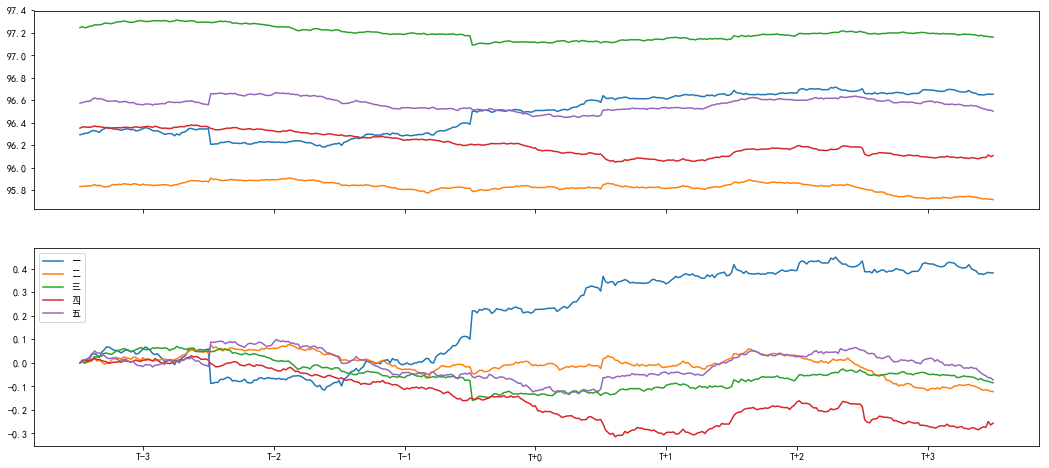

In [123]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
locator = FixedLocator([54*d+26 for d in range(day1+day2+1)])
formatter = FixedFormatter(days)
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex="all")
for ax, pd_data in zip(axes, [pd_data1, pd_data2]):
    labels = pd_data.columns
    for i in range(len(labels)):
        ax.plot(pd_data.index, pd_data.iloc[:, i], label=labels[i])
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(loc="best")

In [120]:
help(ax)

Help on AxesSubplot in module matplotlib.axes._subplots object:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      *fig* is a :class:`matplotlib.figure.Figure` instance.
 |      
 |      *args* is the tuple (*numRows*, *numCols*, *plotNum*), where
 |      the array of subplots in the figure has dimensions *numRows*,
 |      *numCols*, and where *plotNum* is the number of the subplot
 |      being created.  *plotNum* starts at 1 in the upper left
 |      corner and increases to the right.
 |      
 |     

In [112]:
help(ticker)

Help on module matplotlib.ticker in matplotlib:

NAME
    matplotlib.ticker

DESCRIPTION
    Tick locating and formatting
    
    This module contains classes to support completely configurable tick
    locating and formatting. Although the locators know nothing about major
    or minor ticks, they are used by the Axis class to support major and
    minor tick locating and formatting. Generic tick locators and
    formatters are provided, as well as domain specific custom ones.
    
    Default Formatter
    -----------------
    
    The default formatter identifies when the x-data being plotted is a
    small range on top of a large off set. To reduce the chances that the
    ticklabels overlap the ticks are labeled as deltas from a fixed offset.
    For example::
    
       ax.plot(np.arange(2000, 2010), range(10))
    
    will have tick of 0-9 with an offset of +2e3. If this is not desired
    turn off the use of the offset on the default formatter::
    
       ax.get_xaxis().g

In [109]:
formatter = FuncFormatter(func=lambda s, pos: s[0:3])

In [110]:
formatter("T-3_11:30")

'T-3'

In [93]:
"{0:<10}".format("12ttt")

'12ttt     '

In [107]:
f=lambda x, pos: x[0:3]

In [108]:
f("12ttt")

TypeError: <lambda>() missing 1 required positional argument: 'pos'